# <p style="text-align: center;">**Curating metal-organic frameworks to compose robust gas sensor arrays in dilute conditions**</p>

### <p style="text-align: center;">Arni Sturluson, Rachel Sousa, Yujing Zhang, Melanie T. Huynh, Caleb Laird, Arthur H. P. York, Carson Silsby, Chih-Hung Chang, and Cory M. Simon</p>

=================================================================================================================================

In this Notebook we will by analyzing how to choose  different pairs of MOFs can be accurately determine  the composition of CO<sub>2</sub> and SO<sub>2</sub> when they are coated on a Quartz Crystal Microbalance (QCM) to be employed in a sensor array.

To do this we will inspect the CO<sub>2</sub> and SO<sub>2</sub> adsorption isotherms of each MOF and extract the Henry coefficients from each isotherm (See `Extract_Henry.ipynb`) and form a Henry coefficient matrix, <b>H</b>. The <i>Singular Value Decomposition</i> (SVD) is used to factorize <b>H</b> into three matrices that will aid us in analyzing the performance of each MOF pair.

The MOF adsorption data was gathered from various sources. See full citation list at the bottom of the notebook (or click [here](#ref_list))

| MOF | CO<sub>2</sub> Reference | SO<sub>2</sub> Reference |
| :--- |    :----:      | :----:         |
|MFM-600| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|MFM-601| 10.1021/jacs.8b08433 | 10.1021/jacs.8b08433 |
|Mg-MOF-74| 10.1021/cm401270b | 10.1039/c1ee01720a |
|Ni(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|Zn(bdc)(ted)<sub>0.5</sub>| 10.1021/cm401270b | 10.1016/j.micromeso.2009.11.026 |
|MFM-300(In)| 10.1002/adma.201602338 | 10.1002/adma.201602338 |
|NOTT-202a | 10.1021/ja401061m | 10.1021/ja401061m |
|NOTT-300 | 10.1038/nchem.1457 | 10.1038/nchem.1457 |
|Co<sub>3</sub>[Co(CN)<sub>6</sub>]<sub>2</sub> | 10.1021/ic902397w | 10.1021/ic902397w |
|Zn<sub>3</sub>[Co(CN)<sub>6</sub>]<sub>2</sub> | 10.1021/ic902397w | 10.1021/ic902397w |
|KAUST-7 | 10.1038/s41467-019-09157-2 | 10.1038/s41467-019-09157-2 |
|KAUST-8 | 10.1038/s41467-019-09157-2 | 10.1038/s41467-019-09157-2 |

In [1]:
using PyPlot
using Optim
using CSV
using DataFrames
using LaTeXStrings
using Printf
using LinearAlgebra
using Statistics

The .csv file `../data/henry_constants.csv` contains all the Henry coefficients extraced from `Extract_Henry.ipynb`

In [2]:
df_henry = CSV.read("../data/henry_constants.csv")

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_Temperature [K],SO2_henry coefficient [mmol/(g-bar)]
,String,Float64,Int64,Float64
1,MFM601,1.3703,298,97.2407
2,Zn-bdc-ted,2.15867,298,19.1696
3,Ni-bdc-ted,2.2069,298,40.402
4,NOTT-202a,1.37109,293,153.6
5,MFM600,1.41883,298,34.7973
6,NOTT-300,7.96526,293,483.864
7,MFM-300-In,4.60751,298,171.432
8,Zn-CN6,5.17058,298,4.36483
9,Mg-MOF-74,198.82,293,150.413


The QCM-MOF sensors recognize change in mass adsorbed on the MOF coating layer. Thus, we will add two columns to the dataframe with the Henry coefficient units to `g gas / (bar-g MOF)`

In [3]:
mw = Dict("CO2" => 44.01, "SO2" => 64.066)
for gas in ["CO2", "SO2"]
    df_henry[!, Symbol("H_$gas [g/(g-bar)]")] = df_henry[!, Symbol(gas * "_henry coefficient [mmol/(g-bar)]")] * mw[gas] / 1000
end

first(df_henry)

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_Temperature [K],SO2_henry coefficient [mmol/(g-bar)]
,String,Float64,Int64,Float64
1,MFM601,1.3703,298,97.2407


In [4]:
df_henry[!, Symbol("Selectivity CO2/SO2 (moles)")] = df_henry[!, Symbol("CO2_henry coefficient [mmol/(g-bar)]")] ./ df_henry[!, Symbol("SO2_henry coefficient [mmol/(g-bar)]")]
df_henry[!, Symbol("Selectivity SO2/CO2 (moles)")] = df_henry[!, Symbol("SO2_henry coefficient [mmol/(g-bar)]")] ./ df_henry[!, Symbol("CO2_henry coefficient [mmol/(g-bar)]")]
df_henry[!, Symbol("Selectivity CO2/SO2 (mass)")] = df_henry[!, Symbol("H_CO2 [g/(g-bar)]")] ./ df_henry[!, Symbol("H_SO2 [g/(g-bar)]")]
df_henry[!, Symbol("Selectivity SO2/CO2 (mass)")] = df_henry[!, Symbol("H_SO2 [g/(g-bar)]")] ./ df_henry[!, Symbol("H_CO2 [g/(g-bar)]")]

df_henry

,crystal,CO2_henry coefficient [mmol/(g-bar)],CO2_Temperature [K],SO2_henry coefficient [mmol/(g-bar)]
,String,Float64,Int64,Float64
1,MFM601,1.3703,298,97.2407
2,Zn-bdc-ted,2.15867,298,19.1696
3,Ni-bdc-ted,2.2069,298,40.402
4,NOTT-202a,1.37109,293,153.6
5,MFM600,1.41883,298,34.7973
6,NOTT-300,7.96526,293,483.864
7,MFM-300-In,4.60751,298,171.432
8,Zn-CN6,5.17058,298,4.36483
9,Mg-MOF-74,198.82,293,150.413


This Dict will provide a cleaner looking LaTeX string to use in plots for better looking visualizations.

In [5]:
formatted_crystal_names = Dict{AbstractString, AbstractString}()
formatted_crystal_names["MFM601"] = "MFM-601"
formatted_crystal_names["Zn-bdc-ted"] = "Zn(bdc)(ted)\$_{0.5}\$"
formatted_crystal_names["Ni-bdc-ted"] = "Ni(bdc)(ted)\$_{0.5}\$"
formatted_crystal_names["NOTT-202a"] = "NOTT-202a"
formatted_crystal_names["MFM600"] = "MFM-600"
formatted_crystal_names["NOTT-300"] = "NOTT-300"
formatted_crystal_names["MFM-300-In"] = "MFM-300-In"
formatted_crystal_names["Zn-CN6"] = "Zn\$_3\$[Co(CN)\$_6\$]\$_2\$"
formatted_crystal_names["Mg-MOF-74"] = "Mg-MOF-74"
formatted_crystal_names["Co-CN6"] = "Co\$_3\$[Co(CN)\$_6\$]\$_2\$"
formatted_crystal_names["KAUST7"] = "KAUST-7"
formatted_crystal_names["KAUST8"] = "KAUST-8"

"KAUST-8"

Lets create the Henry coefficient matrix, <b>H</b>, and see how it maps <b>p</b> to __m__, or alternatively, how it maps from _composition space_ to _response space_.

`mof2index` is a helper function that maps the name of a MOF to its index in the dataframe.

In [6]:
construct_H_matrix(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1}) = [df_henry[mof, Symbol("H_" * gas * " [g/(g-bar)]")] for mof in mofs, gas in gases]
construct_H_matrix([7, 9], ["SO2", "CO2"])

2×2 Array{Float64,2}:
 10.983    0.202777
  9.63634  8.75008 

In [7]:
function mof2index(mof::AbstractString)
    mask = mof .== df_henry[!, :crystal]
    if sum(mask) > 1
        @error "More than one MOF match the given MOF name"
    elseif sum(mask) == 0
        @error "No MOF matched the given MOF name"
    else
        return argmax(mask)
    end
end
mof1 = mof2index("MFM-300-In")
mof2 = mof2index("Mg-MOF-74")
construct_H_matrix([mof1, mof2], ["SO2", "CO2"])

2×2 Array{Float64,2}:
 10.983    0.202777
  9.63634  8.75008 

In [8]:
# A small test to see if `construct_H_matrix` and `mof2index` are working properly
H_MFM600_and_MFM601 = [1.418831 34.797254; 1.370301 97.240663] .* [44.01 64.066] / 1000
@assert isapprox(construct_H_matrix(mof2index.(["MFM600", "MFM601"]), ["CO2", "SO2"]), H_MFM600_and_MFM601)

# Singular Value Decomposition (SVD)
Now we will factorize <b>H</b> using SVD: <br>
<b>H</b> = <b>U&Sigma;V<sup>T</sup></b> <br>
where;<br> 
<b>U</b> = [<b>u<sub>1</sub>u<sub>2</sub></b>] is an orthogonal matrix with columns that span the column space of <b>H</b>. The columns in <b>U</b> are the left singular vectors of <b>H</b>. <br>
<b>&Sigma;</b> is a diagonal matrix containing the singular values of <b>H</b>; &sigma;<sub>1</sub>(<b>H</b>) and &sigma;<sub>2</sub>(<b>H</b>), running down the diagonal in non-increasing order. The singular values are linked to the singular vectors and govern their importance. <br>
<b>V</b> = [<b>v<sub>1</sub>v<sub>2</sub></b>] is an orthogonal matrix with columns that span the row space of <b>H</b>. The columns in <b>V</b> are the right singular vectors of <b>H</b>. <br><br>
The mapping from composition space to response space by <b>H</b> can be broken down into three transformations: An orthogonal transformation (<b>U</b>), scaling (<b>&Sigma;</b>), and another orthogonal transformation (<b>V<sup>T</sup></b>). <br>
To visualize the three transformations, we will map a circle in composition to an ellipse in response space.

Lets begin by creating a helper function to shift the axes to the origin and make the figures look cleaner

In [9]:
function _pretty_axes(ax::Any, label_coords::Union{Missing, Array{Float64, 2}}=missing)
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position("right")
    ax.yaxis.set_label_position("right")
    ax.xaxis.tick_bottom()
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("bottom")
    ax.spines["left"].set_position("zero")
    ax.spines["right"].set_color("none")
    ax.yaxis.tick_left()
    ax.spines["top"].set_position("zero")
    ax.spines["bottom"].set_color("none")
    ax.set_axisbelow(false)
    # Shift the axis labels to a more fitting position
    if typeof(label_coords) != Missing
        @assert size(label_coords) == (2,2)
        ax.xaxis.set_label_coords(label_coords[1,1], label_coords[1,2])
        ax.yaxis.set_label_coords(label_coords[2,1], label_coords[2,2])
    end    
end

_pretty_axes (generic function with 2 methods)

In [10]:
function plot_response(mofs::Array{Int64, 1}, gases::Array{<:AbstractString, 1})
    H = construct_H_matrix(mofs, gases) ./ 1e6 * 1000 # bar->ppm and g->mg [mg/g-ppm]
    
    N = 250
    # Decompose `H` with SVD. `F` stores U, Σ, V and Vᵀ
    F = svd(H)
    # `θ` and `p` are used to plot a unit circle in composition space
    θ = range(0, stop=2*π, length=N)
    r = 500
    p = r .* transpose(hcat(cos.(θ), sin.(θ))) # The radius of the circle will be 500 ppm
    # The matrix H maps the partial pressures `p` to a response `n`
    n = H * p # [mg/g]
    # This creates a meshgrid used to make the "colorwheel"
    a = range(-r,stop=r,length=N)
    b = range(-r,stop=r,length=N)
    X = [i for i in a, j in b]
    Y = [j for i in a, j in b]
    
    # A nested function to plot eigenvectors from the SVD decomposition
    #TODO Fix `head_width` to scale with response
    function plot_vector(x; width=0.005, head_length=0.05, head_width=0.05, color="k", label="", label_dist=0.05)
        x_plot = x - head_length * x / norm(x)
        plt.arrow(0, 0, x_plot[1], x_plot[2], width=width, head_width=head_width,
            head_length=head_length, fc=color, ec=color, zorder=1000000)
        x_label = x + x / norm(x) * label_dist
        plt.text(x_label[1], x_label[2], label)
    end

    Z = zeros(N, N)
    # The following loop gives each point in the meshgrid a value to determine its color.
    # Points outside of the composition circle, determined by `r`, are given a NaN value
    temp_z = 0.
    for i = 1:N
        for j = 1:N
            if X[i,j]^2 + Y[i,j]^2 > r^2
                temp_z = NaN
            else
                if X[i,j] == 0
                    temp_z = sign(Y[i,j])*π/2
                else
                    temp_z = atan(Y[i,j]/X[i,j])
                end
                if (Y[i,j] > 0 && X[i,j] <= 0) || (Y[i,j] <= 0 && X[i,j] <= 0)
                    temp_z = temp_z + π
                elseif Y[i,j] <= 0 && X[i,j] > 0
                    temp_z = temp_z + 2*π
                end
            end
            Z[i,j] = temp_z
        end
    end
    # A colormap is grabbed from matplotlib.colors and is normalized with respect to our data
    # NaN values are given the color #00FFFFFF (transparent white)
    cmap = plt.get_cmap("hsv")
    cmap.set_bad(color="#FFFFFF00")
    levels = PyPlot.matplotlib.ticker.MaxNLocator(nbins=1000).tick_values(0.0, 2*π)
    cnorm = PyPlot.matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=true)
    
    plt.figure(figsize=(11, 6))
    
    #########################
    ### Composition Space ###
    #########################
    
    ax = plt.subplot(121, aspect="equal")
    rp = range(0.01, stop=1.0, length=40)
    # The circle in composition space is plotted
    ax.pcolormesh(X, Y, Z, cmap=cmap, norm=cnorm)
    ax.plot(p[1,:], p[2,:], c="k", lw=2)
    for j in 1:length(rp)
        p_bar = rp[j] .* p
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plt.plot(p_bar[1, i:i+1], p_bar[2, i:i+1], lw=2, c="k", alpha=1.0, zorder=99)
            end
        end
    end
    
    #plt.axis("equal")
    plt.xlabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[1]))
    plt.ylabel(@sprintf("\$p_{%s}^*\$ (ppm)", gases[2]), rotation=0)

    # The vectors v₁ and v₂ are plotted
    for k = 1:2
        plot_vector(500 * F.V[:, k], color="#a9a9a9", width=7.5, head_width=40., head_length=25.,
            label="\$\\mathbf{v}_$k\$", label_dist=50.)
    end
    
    # The following calls are used to shift and modify the axes
    label_coords = [-0.05 0.55; 0.6 1.02]
    _pretty_axes(ax, label_coords)
    ax.set_xlim([-550, 550])
    ax.set_ylim(ax.get_xlim())
                
    plt.title("Composition Space", fontsize=16)
    plt.tight_layout()
    
    ######################
    ### Response Space ###
    ######################
    
    ax = plt.subplot(122, aspect="equal")
    # We have to reshape the meshgrid, transform it via `H` and reshape it again to its original form.    
    mesh_p = zeros(2,1)
    for i = 1:N
        for j = 1:N
            mesh_p = hcat(mesh_p, [X[i, j], Y[i, j]])
        end
    end
    mesh_p = mesh_p[:,2:end]
    mesh_n = H * mesh_p
    nX = zeros(N, N)
    nY = zeros(N, N)
    for i = 1:N
        for j = 1:N
            nX[i, j] = mesh_n[1, j + (i-1)*N]
            nY[i, j] = mesh_n[2, j + (i-1)*N]
        end
    end
    ax.pcolormesh(nX, nY, Z, cmap=cmap, norm=cnorm)
    ax.plot(n[1,:], n[2,:], c="k", lw=2)

    # The ellipse and black "height" lines are plotted
    for j in 1:length(rp)
        p_bar = rp[j] .* p
        n_bar = H * p_bar
        if mod(j,10) == 0
            for i in 1:length(θ)-1
                plt.plot(n_bar[1, i:i+1], n_bar[2, i:i+1], lw=2, c="k", alpha=1.0, zorder=99)
            end
        end
    end

    # The vectors σ₁u₁ and σ₂u₂ are plotted
    for k = 1:2
        plot_vector(F.U[:, k] * F.S[k] * 500, head_length=0.35, width=0.1,
            head_width=0.45, color="#a9a9a9", label="\$\\sigma_$k\\mathbf{u}_$k\$", label_dist=0.85)
    end
    
    # The following calls are used to shift and modify the axes
    label_coords = [1.05 0.59; 0.67 1.00]
    _pretty_axes(ax, label_coords)
    ax.set_xlim([-7.5, 7.5])
    ax.set_ylim(ax.get_xlim())

    #plt.axis("equal")
    plt.xlabel(@sprintf("\$m_{%s}^*\$ [mg/g]", df_henry[!, :crystal][mofs[1]]))
    plt.ylabel(@sprintf("\$m_{%s}^*\$ [mg/g]", df_henry[!, :crystal][mofs[2]]), rotation=0)
    plt.title("Response Space", fontsize=16)
    plt.tight_layout()
    
    
    plt.savefig(@sprintf("composition_response_of_%i_and_%i.png", mofs[1], mofs[2]), format="png", dpi=300)
end

plot_response(mofs::Array{<:AbstractString, 1}, gases::Array{<:AbstractString, 1}) = plot_response(mof2index.(mofs), gases)

plot_response (generic function with 2 methods)

Lets see how a pair of MOFs in a sensor array respond to a change in gas composition:

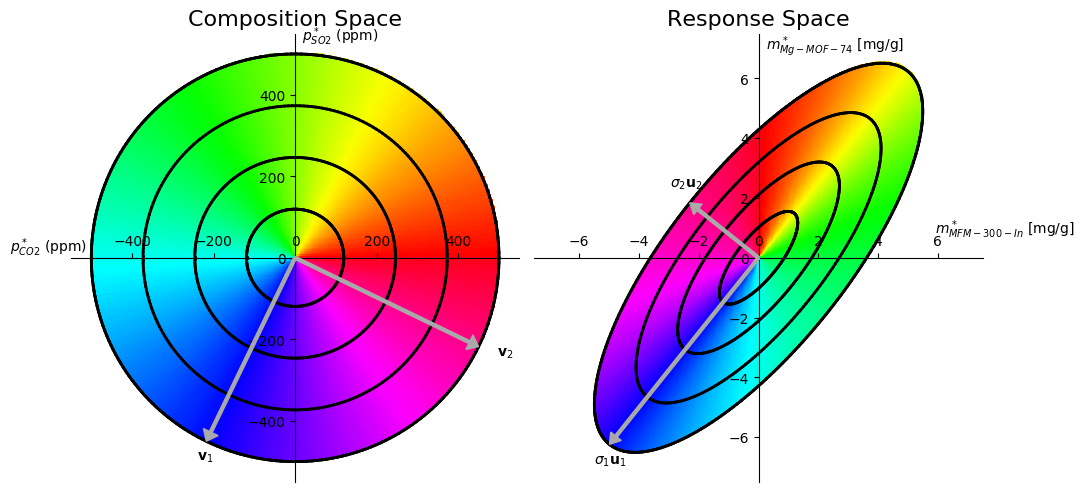

In [11]:
plot_response(["MFM-300-In", "Mg-MOF-74"], ["CO2", "SO2"])

# Error analysis
Now we wish to see what makes a sensor pair robust/poor. The mapping of MFM-300-In and Mg-MOF-74 (shown above) is an example of the mapping from <i>gas composition space</i> to <i>sensor array response space</i> and this visual will aid us in seeing what makes a robust sensor array.<br/>
Below we will show two sensor pairs ({NOTT-202a and KAUST-7} and {MFM-600 and Mg-MOF-74}). One contains MOFs that form a robust sensor array while the other forms a poor sensor array. This is explained by &sigma;<sub>2</sub>(<b>H</b>), which is the length of the semi-minor axis of the ellipse in sensor array response space. If &sigma;<sub>2</sub>(<b>H</b>) is small, the response might not be big enough to distinguish from measurement error, for some changes in gas composition. The measurement error is represented by a hypothetical error zone in the figure below.<br/>
We will also show how a poor sensor array amplifies the error zone if it is mapped back to composition space, elucidating which gas compositions will result in a response that can not be distinguished from measurement error.

In [12]:
function plot_reverse_mapping(mofs::Array{Array{Int64, 1}, 1}, gases::Array{<:AbstractString, 1})
    # We need two H matrices for the two MOF pairs
    H1 = construct_H_matrix(mofs[1], gases)
    H2 = construct_H_matrix(mofs[2], gases)
    
    colors = ["#3cb44b", "#911eb4"]
    labels = [
        @sprintf("Robust Pair: {%s (1) and %s (2)}", formatted_crystal_names[df_henry[!, :crystal][mofs[1][1]]], formatted_crystal_names[df_henry[!, :crystal][mofs[1][2]]]), 
        @sprintf("Poor Pair: {%s (1) and %s (2)}", formatted_crystal_names[df_henry[!, :crystal][mofs[2][1]]], formatted_crystal_names[df_henry[!, :crystal][mofs[2][2]]])
             ]
    zorders = [2.2, 1]
    
    H1 = H1 * 1e6 / 1e6 # g->μg and bar->ppm
    H2 = H2 * 1e6 / 1e6 # g->μg and bar->ppm
    
    # Make sure that the more robust MOF pair is green and has the correct label associated with it
    if cond(H1) > cond(H2)
        colors[1], colors[2] = colors[2], colors[1]
        labels[1], labels[2] = labels[2], labels[1]
        zorders[1], zorders[2], zorders[2], zorders[1]
    end
    
    # We use the same method as in the `plot_response` function. 
    # We need a few more variables to keep track of in this function: 
    # n_err: the error zone circle
    # p1, p2: composition ellipses for the two MOF pairs
    # n1, n2: response ellipses for the two MOF pairs
    # p: composition circle
    θ = range(0, stop=2*π, length=200)
    n_err = 15. .* transpose(hcat(cos.(θ), sin.(θ)))
    p1 = inv(H1) * n_err
    p2 = inv(H2) * n_err
    p = 5 .* transpose(hcat(cos.(θ), sin.(θ)))
    n1 = H1 * p
    n2 = H2 * p

    # a,b are used to make a meshgrid (assigned to X and Y)
    # We use a Gaussian distribution to model the error zone. σ parameter chosen arbitrarily.
    a = range(-45,stop=45,length=201)
    b = range(-45,stop=45,length=201)
    X = [i for i in a, j in b]
    Y = [j for i in a, j in b]
    σ = 30
    z = (sqrt(2 * π * σ^2))^(-1) .* exp.(-(X.^2 .+ Y.^2) ./ (2 * σ))
    levels = PyPlot.matplotlib.ticker.MaxNLocator(nbins=100).tick_values(minimum(z), maximum(z))
    cmap = plt.get_cmap("YlOrRd")
    my_cmap = cmap(1:cmap.N)
    # Here I rigged a colormap to become transparent at one end
    for i = 1:10
        my_cmap[i, 4] = 0.1 * (i-1)
    end
    my_cmap = PyPlot.matplotlib.colors.ListedColormap(my_cmap)
    norm1 = PyPlot.matplotlib.colors.BoundaryNorm(levels, ncolors=my_cmap.N, clip=true)

    fig = plt.figure(figsize=(12, 5.5))
    
    ##########################
    ######  Top Figure  ######
    ##########################
    
    ##########
    ### Left #
    ##########

    ax = plt.subplot(121, aspect="equal")  
    plt.plot(p[1,:], p[2,:], lw=5, c="k")
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)", fontsize=16)
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0, fontsize=16)
    label_coords = [0.0 0.65; 0.65 0.98]
    _pretty_axes(ax, label_coords)
    ax.spines["left"].set_linewidth(2.5)
    ax.spines["top"].set_linewidth(2.5)
    ax.set_xlim([-9, 9])
    ax.set_ylim([-9, 9])    
    plt.title("Composition Space", fontsize=16)
    plt.tick_params(labelsize=12)
    
    ###########
    # Right ###
    ###########
      
    ax = plt.subplot(122, aspect="equal")

    plt.plot(n1[1,:], n1[2,:], lw=5, c=colors[1], zorder=zorders[1])
    plt.plot(n2[1,:], n2[2,:], lw=5, c=colors[2], zorder=zorders[2])
    ax.pcolormesh(X, Y, z, cmap=my_cmap, norm=norm1)

    plt.xlabel("\$m^*_{MOF_1}\$ (μg/g)", fontsize=16)
    plt.ylabel("\$m^*_{MOF_2}\$ (μg/g)", rotation = 0, fontsize=16)
    label_coords = [1.05 0.62; 0.67 1.005]
    _pretty_axes(ax, label_coords)
    ax.spines["left"].set_linewidth(2.5)
    ax.spines["top"].set_linewidth(2.5)    
    ax.set_xlim([-75, 75])
    ax.set_ylim([-75, 75])
    
    plt.title("Response Space", fontsize=16)
    plt.tick_params(labelsize=12)
    
    # Add an arrow showing the mapping by overlaying a new subplot on the figure
    ax = fig.add_subplot(111)
    #plt.xlim([0,11])
    #plt.ylim([-5,5])
    #plt.arrow(4.875, 2.5, 1.1, 0.0, color="k", width=0.01, head_width=0.1, zorder=9999)
    #plt.text(5.3, 2.6, "\$\\mathbf{H}\$", fontsize=20)
    ax.axis("off")
    # A rigged legend using Line2D objects
    custom_lines = [PyPlot.matplotlib.lines.Line2D([0], [0], color=colors[1], lw=4),
                    PyPlot.matplotlib.lines.Line2D([0], [0], color=colors[2], lw=4)]
    ax.legend(custom_lines, labels, loc=3, handlelength=5, fontsize=14, framealpha=1.0)
    
    plt.tight_layout()
    plt.savefig("reverse_mapping_noarrow_a.pdf", dpi=300, format="pdf")
    plt.show()
    
    
    fig = plt.figure(figsize=(12, 5.5))
    
    ############################
    ###### Bottom Figure  ######
    ############################
        
    ##########
    ### Left #
    ##########

    ax = plt.subplot(121, aspect="equal")
    plt.plot(p1[1,:], p1[2,:], lw=5, c=colors[1], zorder=zorders[1])
    plt.plot(p2[1,:], p2[2,:], lw=5, c=colors[2], zorder=zorders[2])
    plt.xlabel("\$p^*_{CO_2}\$ (ppm)", fontsize=16)
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0, fontsize=16)
    #label_coords = [-0.15 0.55; 0.6 0.95]
    label_coords = [0.0 0.65; 0.65 0.98]
    _pretty_axes(ax, label_coords)
    ax.spines["left"].set_linewidth(2.5)
    ax.spines["top"].set_linewidth(2.5)
    ax.set_xlim([-9, 9])
    ax.set_ylim([-9, 9])

    plt.title("Composition Space", fontsize=16)
    plt.tick_params(labelsize=12)
    
    ###########
    # Right ###
    ###########
    
    ax = plt.subplot(122, aspect="equal")
    ax.set_ylim([-15, 15])    
    plt.plot(n_err[1,:], n_err[2,:], lw=5, c="k", label="Error zone")
    ax.pcolormesh(X, Y, z, cmap=my_cmap, norm=norm1)

    plt.xlabel("\$m^*_{MOF_1}\$ (μg/g)", fontsize=16)
    plt.ylabel("\$m^*_{MOF_2}\$ (μg/g)", rotation = 0, fontsize=16)
    #label_coords = [1.05 0.56; 0.61 0.99]
    label_coords = [1.05 0.62; 0.67 1.005]
    _pretty_axes(ax, label_coords)
    ax.spines["left"].set_linewidth(2.5)
    ax.spines["top"].set_linewidth(2.5)    
    ax.set_xlim([-75, 75])
    ax.set_ylim([-75, 75])
    
    plt.title("Response Space", fontsize=16)
    plt.tick_params(labelsize=12)

    # Add an arrow showing the mapping by overlaying a new subplot on the figure    
    #ax = fig.add_subplot(111)
    #ax.set_xlim([0,11])
    #ax.set_ylim([-5,5])
    #plt.arrow(6.25, 2.5, -1.1, 0.0, color="k", width=0.01, head_width=0.1, zorder=9999)
    #plt.text(5.25, 2.6, "\$\\mathbf{H}^{-1}\$", fontsize=20)
    #ax.axis("off")

    plt.tight_layout()
    plt.savefig("reverse_mapping_noarrow_b.pdf", dpi=300, format="pdf")
    plt.show()
end
plot_reverse_mapping(mofs::Array{Array{String, 1}, 1}, gases::Array{<:AbstractString, 1}) = plot_reverse_mapping([mof2index.(mofs[1]), mof2index.(mofs[2])], gases)

plot_reverse_mapping (generic function with 2 methods)

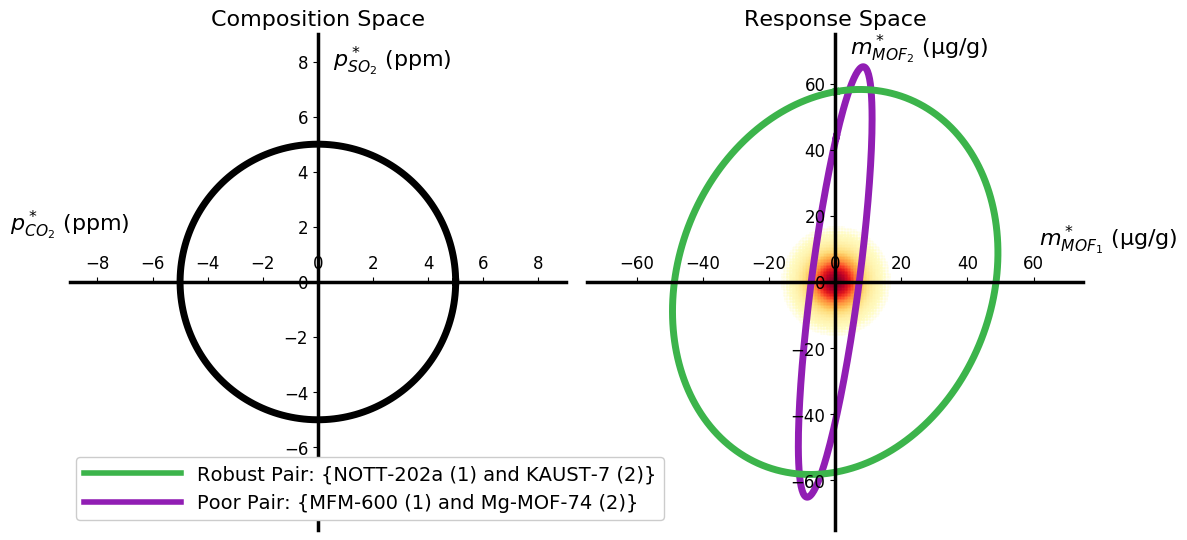

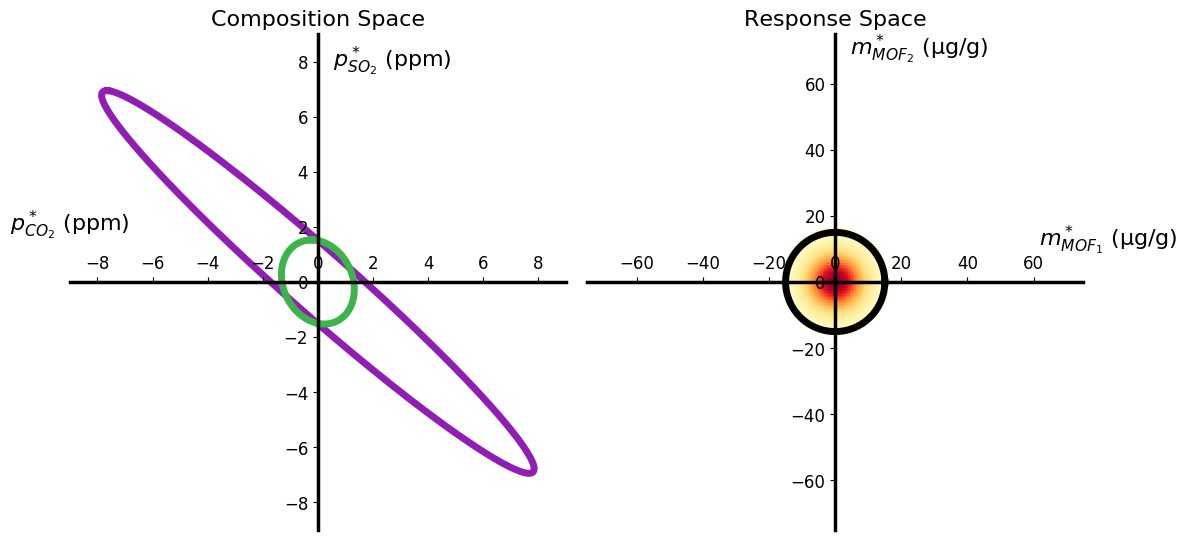

In [13]:
plot_reverse_mapping([["NOTT-202a","KAUST7"],["MFM600","Mg-MOF-74"]], ["CO2", "SO2"])

Here we lay down the groundwork for our SVD analysis<br />
We begin by constructing a matrix, **H**, containing the Henry coefficients for the gas-MOF pair we are interested in

Lets look at the response generated by every combination of 2 MOFs from our subset of MOFs.</br>
We illustrate the magnitude of the smallest singular value, &sigma;<sub>2</sub>(<b>H</b>), with a bar over each ellipse which is proportional to the biggest &sigma;<sub>2</sub>(<b>H</b>) in the set.

In [14]:
function plot_all_responses(gases::Array{<:AbstractString, 1}, indicator_type::Symbol=:sigma2)
    r = 500
    N = 250
    θ = range(0, stop=2*π, length=N)
    p = r .* transpose(hcat(cos.(θ), sin.(θ)))
    n_mofs = length(df_henry[!, :crystal])
    a = range(-r,stop=r,length=N)
    b = range(-r,stop=r,length=N)
    X = [i for i in a, j in b]
    Y = [j for i in a, j in b]
    
    height_ratios = ones(2*n_mofs) * 1.25
    width_ratios = ones(n_mofs)
    hspace = 0.1
    for i = 1:2:2*n_mofs
        height_ratios[i] = 0.1
    end
    fig, axs = plt.subplots(nrows=2*n_mofs, ncols=n_mofs, figsize=(20, 20),
                    gridspec_kw = Dict("height_ratios" => height_ratios,
                                       "width_ratios" => width_ratios,
                                       "hspace" => hspace))
    mof_no = 0
    indicator = zeros(n_mofs, n_mofs)
    
    Z = zeros(N, N)
    # The following loop gives each point in the meshgrid a value to determine its color.
    # Points outside of the composition circle, determined by `r`, are given a NaN value
    temp_z = 0.
    for i = 1:N
        for j = 1:N
            if X[i,j]^2 + Y[i,j]^2 > r^2
                temp_z = NaN
            else
                if X[i,j] == 0
                    temp_z = sign(Y[i,j])*π/2
                else
                    temp_z = atan(Y[i,j]/X[i,j])
                end
                if (Y[i,j] > 0 && X[i,j] <= 0) || (Y[i,j] <= 0 && X[i,j] <= 0)
                    temp_z = temp_z + π
                elseif Y[i,j] <= 0 && X[i,j] > 0
                    temp_z = temp_z + 2*π
                end
            end
            Z[i,j] = temp_z
        end
    end
    # A colormap is grabbed from matplotlib.colors and is normalized with respect to our data
    # NaN values are given the color #00FFFFFF (transparent white)
    cmap = plt.get_cmap("hsv")
    cmap.set_bad(color="#ffe11900")
    levels = PyPlot.matplotlib.ticker.MaxNLocator(nbins=1000).tick_values(0.0, 2*π)
    cnorm = PyPlot.matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=true)
    
    
    for i = 1:2:2*n_mofs
        for j = 1:n_mofs

            # The response generated by having two of the same MOFs is an underdetermined problem with infinite solutions
            if i+1 == 2*j
                #axs[i+1, j].set_facecolor("#a9a9a9")
                axs[i+1, j].set_xticks([])
                axs[i+1, j].set_yticks([])
                axs[i+1, j].axis("off")
                imgstring = @sprintf("../data/cif_viz/small_%s.jpg", df_henry[!, :crystal][ceil(Int,i/2)])
                if isfile(imgstring)
                    img = PyPlot.matplotlib.image.imread(imgstring)
                    axs[i+1, j].imshow(img)
                end
                
                
            elseif i > 2*j
                axs[i,j].axis("off")
                axs[i+1,j].axis("off")
                continue
            else
                axs[i+1, j].set_xticks([])
                axs[i+1, j].set_yticks([])
                
                # Set ticks and labels on top right plot
                axs[2, n_mofs].set_xlabel("\$m_1\$ [mg/g]")
                axs[2, n_mofs].set_ylabel("\$m_2\$ [mg/g]", rotation=0)
                axs[2, n_mofs].xaxis.set_label_coords(0.93, 0.45)
                axs[2, n_mofs].yaxis.set_label_coords(0.85, 0.95)                
                axs[2, n_mofs].set_yticks([-10., 10.])
                axs[2, n_mofs].set_xticks([-10., 10.])

                H = construct_H_matrix([ceil(Int, i/2), j], gases) * 1000 / 1e6 #g->mg, bar->ppm
                F = svd(H)
                n = H * p
                mesh_p = zeros(2,1)
                for i = 1:N
                    for j = 1:N
                        mesh_p = hcat(mesh_p, [X[i, j], Y[i, j]])
                    end
                end
                mesh_p = mesh_p[:,2:end]
                mesh_n = H * mesh_p
                nX = zeros(N, N)
                nY = zeros(N, N)
                for i = 1:N
                    for j = 1:N
                        nX[i, j] = mesh_n[1, j + (i-1)*N]
                        nY[i, j] = mesh_n[2, j + (i-1)*N]
                    end
                end
                axs[i+1, j].pcolormesh(nX, nY, Z, cmap=cmap, norm=cnorm)
                axs[i+1, j].plot(n[1,:], n[2,:], c="k", lw=2)


                if indicator_type == :area
                    indicator[ceil(Int,i/2), j] = π * F.S[1] * F.S[2]
                elseif indicator_type == :sigma1
                    indicator[ceil(Int,i/2), j] = F.S[1]
                elseif indicator_type == :sigma2
                    indicator[ceil(Int,i/2), j] = F.S[2]
                else
                    error("indicator_type not recognized. Try `:area`, `:sigma1` or `:sigma2`")
                end

                # Make the ellipse look nice plot
                _pretty_axes(axs[i+1, j])
                axs[i+1, j].axis("equal")
                        
            end
            
            if i == 1
                ttl = axs[i, j].set_title(formatted_crystal_names[df_henry[!, :crystal][j]], y=0.6)
                #ttl.set_position([.5, 1.05])
            end
            if 2*j == i+1
                    axs[i+1, j].text(-50, 110, formatted_crystal_names[df_henry[!, :crystal][ceil(Int,i/2)]], 
                            size=12, verticalalignment = "center", rotation = 90)
            end
        end
    end
        
    best_ellipse = argmax(indicator)
    max_indicator = maximum(indicator)
    best_xlims = axs[best_ellipse[1]*2, best_ellipse[2]].get_xlim()
    best_ylims = axs[best_ellipse[1]*2, best_ellipse[2]].get_ylim()
    if (best_xlims[2]-best_xlims[1]) > (best_ylims[2]-best_ylims[1])
        best_ylims = best_xlims
    else
        best_xlims = best_ylims
    end
                
    for i = 1:2:2*n_mofs
        for j = 1:n_mofs
            if i+1 == 2*j || i > 2*j
                axs[i, j].axis("off")
                continue
            else
                # Fix the limits on the ellipse plots
                axs[i+1, j].set_xlim(best_xlims)
                axs[i+1, j].set_ylim(best_ylims)
                # Make a discrimination bar ("health bar")
                axs[i, j].axis("off")
                old_xlim = axs[i, j].get_xlim()
                old_ylim = axs[i, j].get_ylim()
                width = (old_xlim[2] - old_xlim[1]) * indicator[ceil(Int, i/2), j] / max_indicator
                rect = PyPlot.matplotlib.patches.Rectangle([old_xlim[1], old_ylim[1]], width,
                        old_ylim[2]-old_ylim[1])
                axs[i, j].add_patch(rect)
                axs[i, j].plot([old_xlim[1], old_xlim[1], old_xlim[2], old_xlim[2], old_xlim[1]], 
                                        [old_ylim[1], old_ylim[2], old_ylim[2], old_ylim[1], old_ylim[1]], 
                                        lw=3, color="k", zorder=999)
                axs[i, j].set_xlim(old_xlim)
                axs[i, j].set_ylim(old_ylim)  
            end
        end        
    end
    axs[best_ellipse[1]*2, best_ellipse[2]].set_facecolor("#ffe119")
                    
    # Bottom left plot
    new_ax = fig.add_subplot(223, aspect="equal")
    new_ax.plot(p[1,:], p[2,:], lw=3, c="k")
    new_ax.pcolormesh(X, Y, Z, cmap=cmap, norm=cnorm)

    plt.xlabel("\$p^*_{CO_2}\$ (ppm)", fontsize=20)
    plt.ylabel("\$p^*_{SO_2}\$ (ppm)", rotation = 0, fontsize=20)
    label_coords = [1.15 0.55; 0.6 0.95]
    _pretty_axes(new_ax, label_coords)
    new_ax.set_xlim([-750, 750])
    new_ax.set_ylim([-750, 750])
    plt.tick_params(labelsize=18)

    new_ax2 = fig.add_subplot(111)
    new_ax2.set_xlim(-10, 10)
    new_ax2.set_ylim(-10, 10)
    new_ax2.arrow(-2.5, -2.5, 1.5, 1.5, color="k", width=0.1, head_width=0.5, zorder=9999)
    new_ax2.text(-2.5, -1.25, "\$\\mathbf{H}\$", fontsize=60)
    new_ax2.axis("off")
                    
    plt.tight_layout()
    plt.savefig("all_responses_" * string(indicator_type) * ".png", format="png", dpi=300)
    plt.show()
    return (max_indicator, [df_henry[!, :crystal][best_ellipse[1]], df_henry[!, :crystal][best_ellipse[2]]])
end

plot_all_responses (generic function with 2 methods)

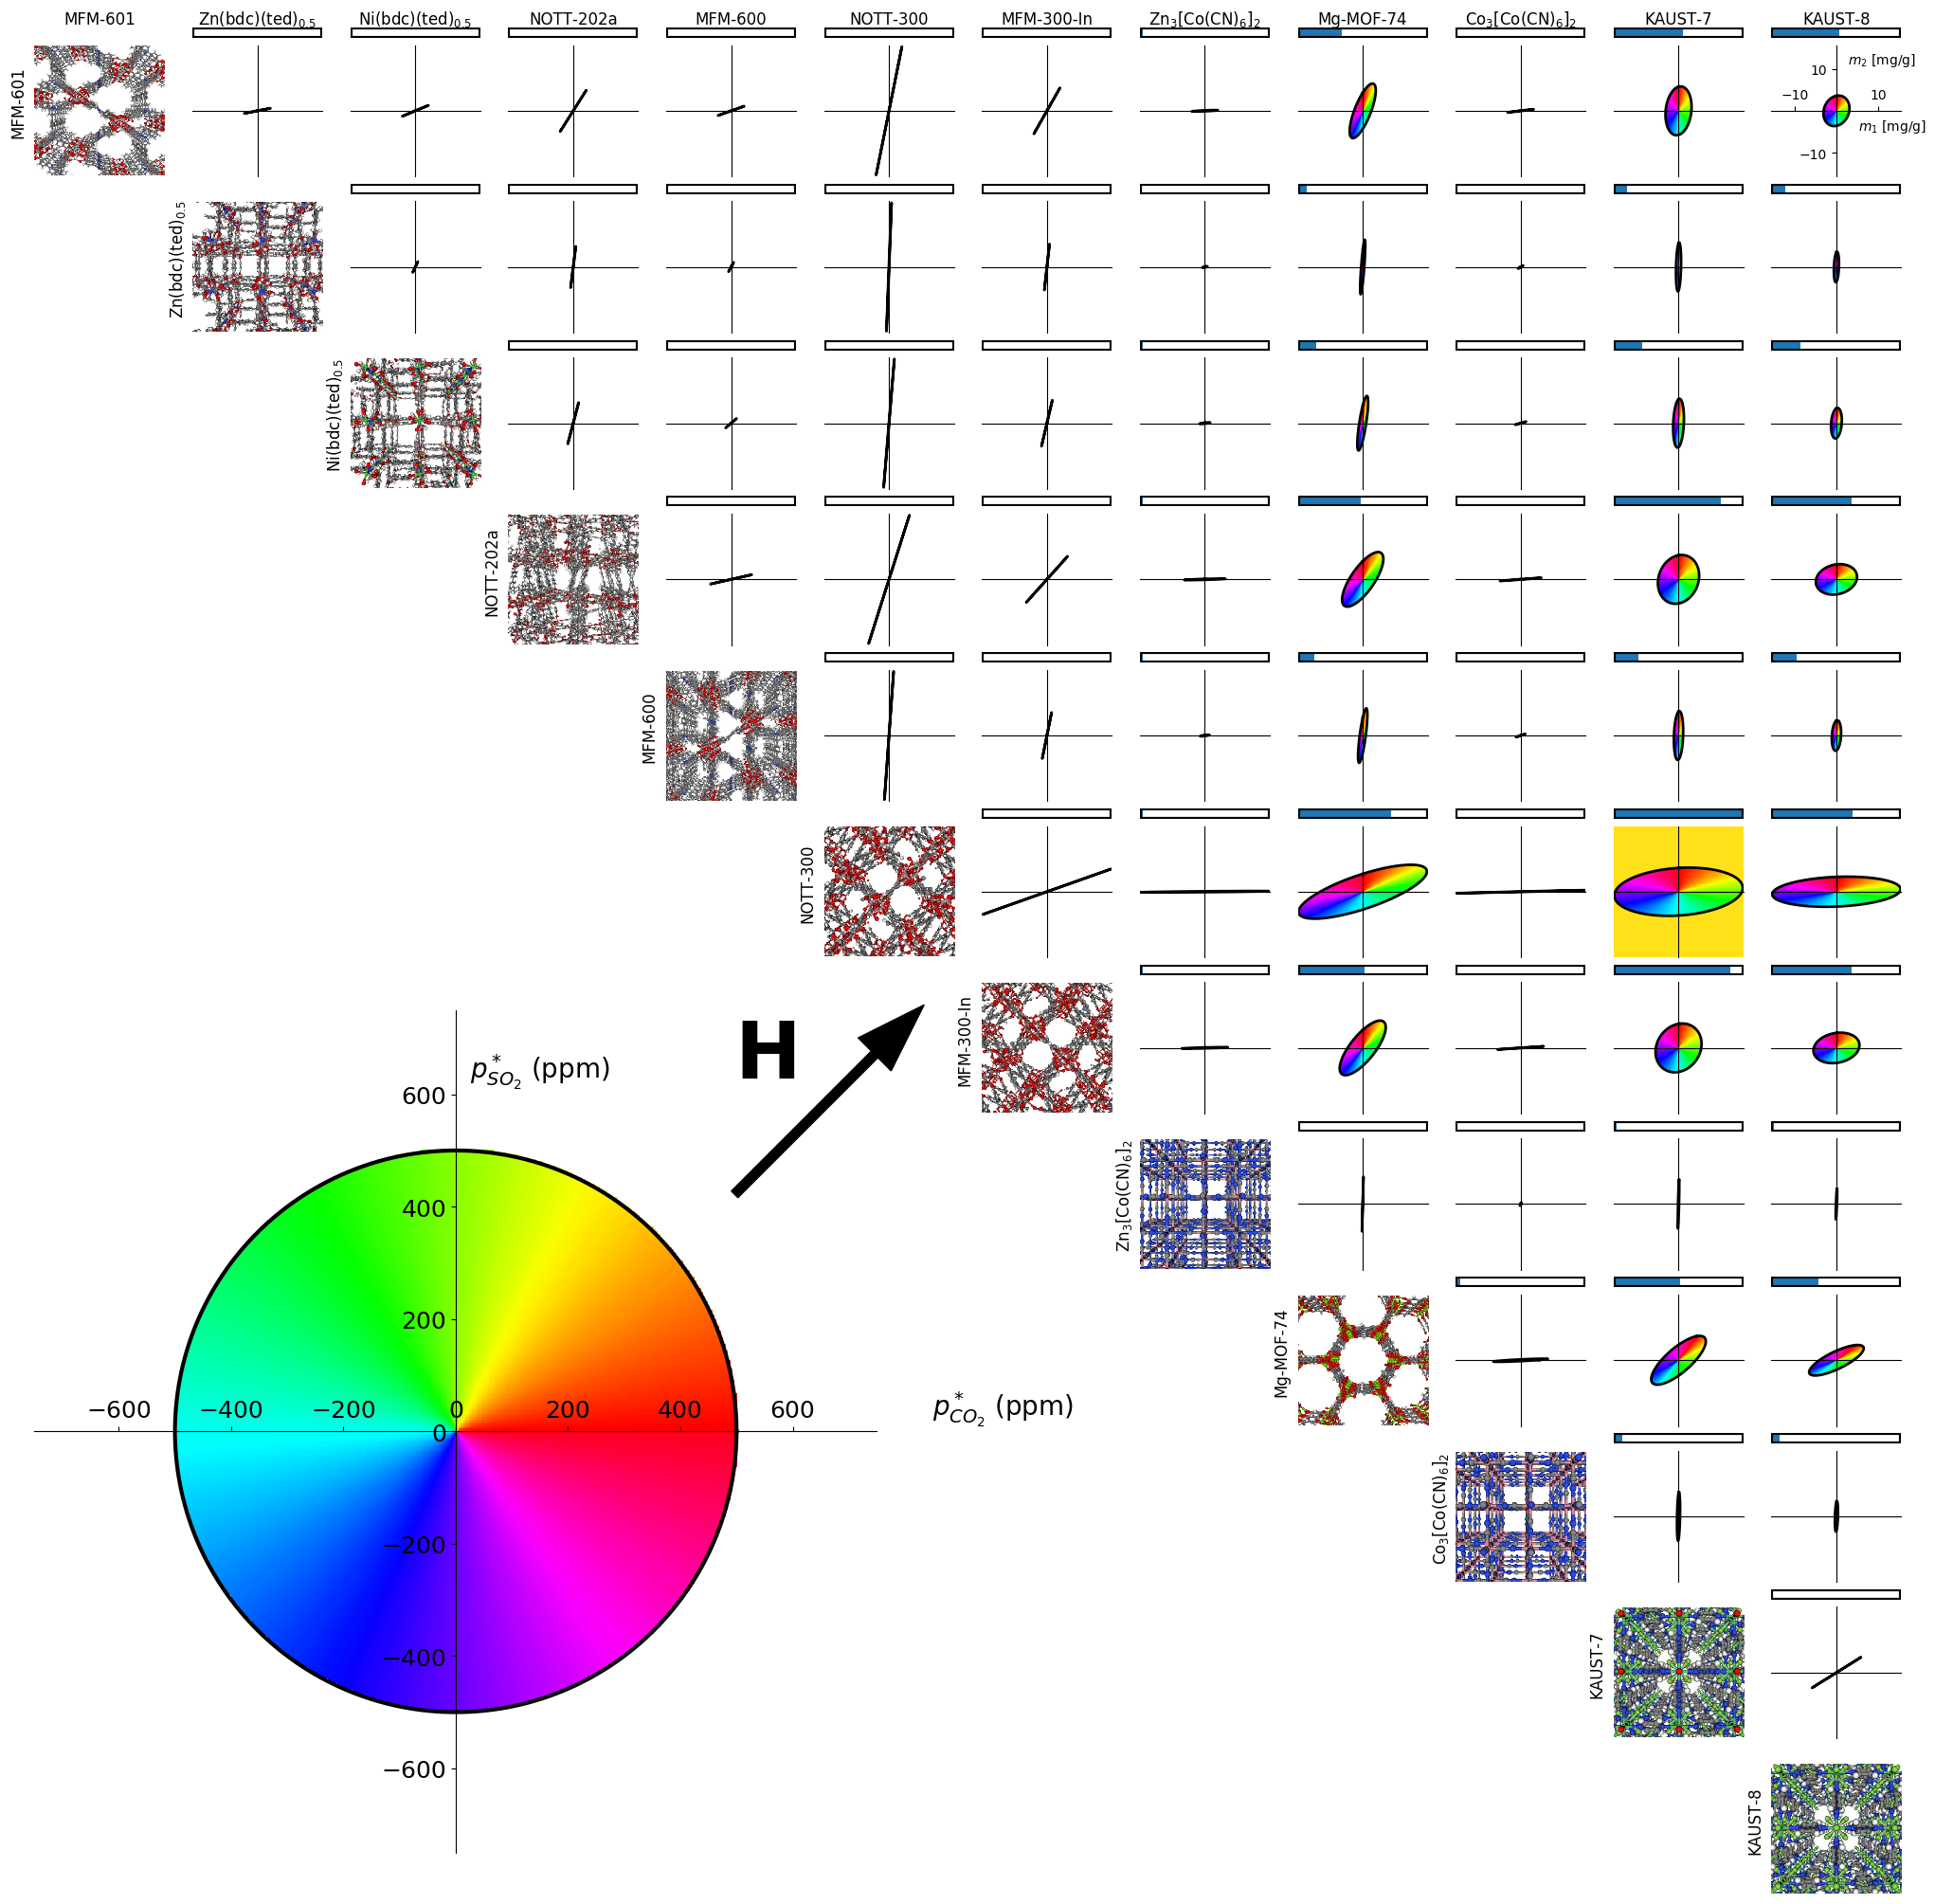

(0.011473804484267866, ["NOTT-300", "KAUST7"])

In [15]:
(max_sigma2, best_pair) = plot_all_responses(["CO2", "SO2"], :sigma2)

## MOF triads
Above we see the best MOF pairs to use in a robust sensor array, but what about MOF triads? Adding a new MOF to the sensor array adds more information to the mix, but there is measurement error associated with the new MOF. So could a new MOF have a detrimental effect on a sensor array?

The upper bound of the error in calculated composition for a determined system (equal number of gases and MOFs) is</br> 
||<b>&delta;p</b>||<sub>2</sub> &le; ||<b>H<sup>-1</sup></b>||<sub><i>op</i></sub>(||<b>&delta;m</b>|| + ||<b>&delta;H</b>||<sub><i>op</i></sub> ||<b>p</b>||)</br>
The upper bound of the error for an overdetermined system is then</br>
||<b>&delta;p</b>||<sub>2</sub> &le; ||<b>H<sup>+</sup></b>||<sub><i>op</i></sub> ( ||<b>&delta;m</b>|| + ||<b>&delta;H</b>||<sub><i>op</i></sub> ||<b>p</b>|| ) + ||(<b>H<sup>T</sup>H</b>)<sup><b>-1</b></sup>||<sub><i>op</i></sub> || (<b>&delta;H</b>)<sup><b>T</b></sup>||<sub><i>op</i></sub> ||<b>e</b>||</br></br>
Assuming there is no error in <b>H</b>, the upper bound of the calculated composition is determined by the operator norm of the inverse of <b>H</b> (or the left inverse if the system is overdetermined) and the measurement error. We also assume that the measurement error is identical between QCM sensors</br>
(such that ||<b>&delta;m</b>|| = &radic;N |&delta;m|). </br>
Here we show that there are some MOF triads that are worse off when adding a third MOF to the pair, based on the upper bounds of the magnitude of the error in calculated composition:

In [16]:
# examines H matrices where the additional row on H3 is the MOF from row 2
# 792 possibilities total (66*12)
function find_bad_triads(verbose::Bool=false)
    N = length(df_henry[!, :crystal])
    num = 0
    for a=1:N
        for b=a+1:N
            H2 = construct_H_matrix([a,b], ["CO2", "SO2"])
            F2 = svd(H2)
            δp2 = 1 / F2.S[2] * sqrt(2)         # 1/F2.S[2] is the largest singluar value of H2^{-1}
            for c=b+1:N
                H3 = construct_H_matrix([a,b,c], ["CO2", "SO2"])
                F3 = svd(H3)
                δp3 = 1 / F3.S[2] * sqrt(3)
                # compare δp values
                if (δp3 > δp2)
                    num += 1
                    if verbose
                        @printf("The pair: {%s and %s}: σ_2(pair) = %.3f", df_henry[!, :crystal][a], df_henry[!, :crystal][b], F2.S[2])
                        @printf("\n\t is worse off after adding %s: σ_2(triad) = %.3f\n====================\n", df_henry[!, :crystal][c], F3.S[2])
                    end
                end
            end
        end
    end
end
find_bad_triads(true)

The pair: {MFM601 and Zn-bdc-ted}: σ_2(pair) = 0.082
	 is worse off after adding NOTT-202a: σ_2(triad) = 0.088
The pair: {MFM601 and Zn-bdc-ted}: σ_2(pair) = 0.082
	 is worse off after adding MFM600: σ_2(triad) = 0.088
The pair: {MFM601 and Zn-bdc-ted}: σ_2(pair) = 0.082
	 is worse off after adding NOTT-300: σ_2(triad) = 0.082
The pair: {MFM601 and Zn-bdc-ted}: σ_2(pair) = 0.082
	 is worse off after adding MFM-300-In: σ_2(triad) = 0.088
The pair: {MFM601 and Ni-bdc-ted}: σ_2(pair) = 0.067
	 is worse off after adding NOTT-202a: σ_2(triad) = 0.079
The pair: {MFM601 and Ni-bdc-ted}: σ_2(pair) = 0.067
	 is worse off after adding MFM600: σ_2(triad) = 0.073
The pair: {MFM601 and Ni-bdc-ted}: σ_2(pair) = 0.067
	 is worse off after adding NOTT-300: σ_2(triad) = 0.069
The pair: {MFM601 and Ni-bdc-ted}: σ_2(pair) = 0.067
	 is worse off after adding MFM-300-In: σ_2(triad) = 0.072
The pair: {MFM601 and MFM600}: σ_2(pair) = 0.038
	 is worse off after adding NOTT-300: σ_2(triad) = 0.039
The pair: {M

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = find_bad_triads(::Bool) at In[16]:4
└ @ Main ./In[16]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = find_bad_triads(::Bool) at In[16]:19
└ @ Main ./In[16]:19
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = find_bad_triads(::Bool) at In[16]:19
└ @ Main ./In[16]:19
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = find_bad_triads(::Bool) at In[16]:20
└ @ Main ./In[16]:20


Even though the upper bound of the magnitude of the error in the calculated composition, the average error will be lower. In the paper the expected value of the magnitude of the error in the calculated composition, ||<b>&delta;p</b>||, defined by the equation <b>&delta;p</b> = <b>H<sup>-1</sup>&delta;m</b>, is related to the Frobenius norm of <b>H<sup>-1</sup></b>.</br>
`mean_p_norm` is meant to simulate ||<b>&delta;p</b>|| by adding a Gaussian noise to the measurement, <b>&sigma;m</b>.

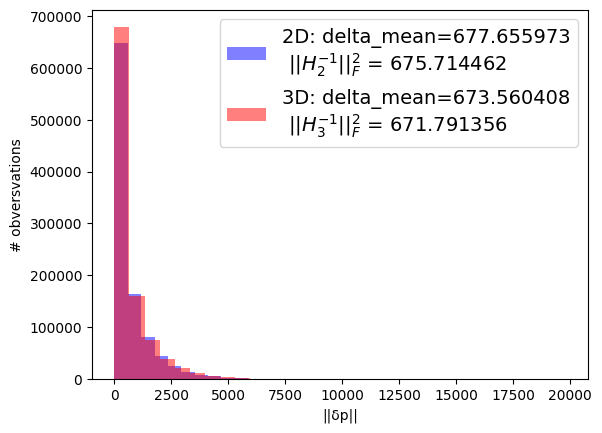

([1265.7564610726954, 836.6081292725736, 46.34642075739004, 36.81987441594594, 8.42040010928508, 2890.8665869422343, 998.0319058638692, 474.6854210476906, 1518.626556656891, 419.537908386357  …  192.22730598107563, 995.0118679006588, 3850.6667138879043, 2723.7306200079743, 169.96900750312724, 5143.494220662908, 18.424288458957914, 861.060434863532, 312.1079017445503, 1.0269297485423163], 675.7144615222307, [59.36220775957405, 66.09306287249636, 1382.057866662962, 46.65912498390969, 612.1925658659676, 647.546638730498, 473.1354292855492, 929.1406817498668, 628.9710241085876, 125.94507328561525  …  424.94505604424995, 470.46316481123085, 301.9549061654809, 6.401376120981885, 122.94037868645408, 507.6301265943267, 374.23323957075104, 10.450286653191345, 198.6944180297959, 901.6739726008354], 671.7913561748206)

In [17]:
function mean_p_norm(H2::Array{Float64, 2}, H3::Array{Float64, 2}, n_sims::Int)
    @assert size(H2) == (2,2) && size(H3) == (3,2)
    p = randn(2,1)
    p = p ./ norm(p)
    function sim_p̃(H, p)
        # true m
        m = H * p
        # simulated m
        m̃ = m + randn(length(m))
        p̃ = H \ m̃
        return p̃
    end
    
    δps2 = [norm(sim_p̃(H2, p) - p)^2 for i = 1:n_sims]
    δps3 = [norm(sim_p̃(H3, p) - p)^2 for i = 1:n_sims]
    
    inv_H2 = inv(H2)
    frob_norm_inv_H2² = norm(inv_H2)^2
    inv_H3 = inv(H3'*H3)*H3'
    frob_norm_inv_H3² = norm(inv_H3)^2  
    
    fig = plt.figure()
    plt.hist(δps2, color="b", alpha=0.5, label=@sprintf("2D: delta_mean=%.6f\n ||\$H^{-1}_2\$||\$^2_F\$ = %.6f", mean(δps2), frob_norm_inv_H2²), bins=30)
    plt.hist(δps3, color="r", alpha=0.5, label=@sprintf("3D: delta_mean=%.6f\n ||\$H^{-1}_3\$||\$^2_F\$ = %.6f", mean(δps3), frob_norm_inv_H3²), bins=30)
    plt.legend(prop=Dict("size"=>14))
    plt.xlabel("||δp||")
    plt.ylabel("# obversvations")
    plt.show()
    return δps2, frob_norm_inv_H2², δps3, frob_norm_inv_H3²
end
H2 = construct_H_matrix([1,5], ["CO2", "SO2"])
H3 = construct_H_matrix([1,5,6], ["CO2", "SO2"])
δps2, frob_norm_inv_H2², δps3, frob_norm_inv_H3² = mean_p_norm(H2, H3, 1000000)

<a id='ref_list'></a>
# **MOF References**
## MFM-600 & MFM-601
> Exceptional Adsorption and Binding of Sulfur Dioxide in a Robust Zirconium-Based Metal–Organic Framework<br />
Joseph H. Carter, Xue Han, Florian Y. Moreau, Ivan da Silva, Adam Nevin, Harry G. W. Godfrey, Chiu C. Tang, Sihai Yang, and Martin Schröder<br />
Journal of the American Chemical Society 2018 140 (46), 15564-15567<br />
DOI: 10.1021/jacs.8b08433
## MFM-300(In)
> Highly selective carbon dioxide adsorption in a water-stable indium-organic framework material<br/>
Jinjie Qian, Feilong Jiang, Daqiang Yuan, Mingyan Wu, Shuguan Zhang, Linjie Zhang and Maochun Hong<br/>
Chem. Commun., 2012,48, 9696-9698 <br/>
DOI: 10.1039/C2CC35068H
## NOTT-202a
> A partially interpenetrated metal-organic framework for selective hysteretic sorption of carbon dioxide<br/>
Sihai Yang, Xiang Lin, William Lewis, Mikhail Suyetin, Elena Bichoutskaia, Julia E. Parker, Chiu C. Tang, David R. Allan, Pierre J. Rizkallah, Peter Hubberstey, Neil R. Champness, K. Mark Thomas, Alexander J. Blake and Martin Schröder<br/>
Nature Materials volume 11, pages 710–716 (2012)<br/>
DOI: 10.1038/nmat3343
## NOTT-300
> Selectivity and direct visualization of carbon dioxide and sulfur dioxide in a decorated porous host<br />
Sihai Yang, Junliang Sun, Anibal J. Ramirez-Cuesta, Samantha K. Callear, William I. F. David, Daniel P. Anderson, Ruth Newby, Alexander J. Blake, Julia E. Parker, Chiu C. Tang & Martin Schröder<br />
Nature Chemistry 2012 887 (4)<br />
DOI: 10.1038/nchem.1457
## Mg-MOF-74
> Dramatic tuning of carbon dioxide uptake via metal substitution in a coordination polymer with cylindrical pores<br/>
Stephen R. Caskey, Antek G. Wong-Foy and Adam J. Matzger<br/>
J. Am. Chem. Soc., 2008, 130 (33), pp 10870–10871<br/>
DOI: 10.1021/ja8036096
## Ni(bdc)(ted)<sub>0.5</sub>
> Amine functionalised metal organic frameworks (MOFs) as adsorbents for carbon dioxide<br/>
Bjørnar Arstad, Helmer Fjellvåg, Kjell Ove Kongshaug, Ole Swang, Richard Blom<br/>
Adsorption (2008) 14: 755.<br/>
DOI: 10.1007/s10450-008-9137-6
## Zn(bdc)(ted)<sub>0.5</sub>
> Rigid and Flexible: A Highly Porous Metal–Organic Framework with Unusual Guest‐Dependent Dynamic Behavior<br/>
Danil N. Dybtsev Dr.  Hyungphil Chun Dr.  Kimoon Kim Prof. Dr.</br>
Angewandte Chemie International Edition (2004), 43: 5033-5036</br>
DOI: 10.1002/anie.200460712

> Synthesis, X-ray crystal structures, and gas sorption properties of pillared square grid nets based on paddle-wheel motifs: Implications for hydrogen storage in porous materials</br>
Chun, H. , Dybtsev, D. N., Kim, H. and Kim, K.</br>
Chemistry – A European Journal (2005), 11: 3521-3529</br> 
DOI: 10.1002/chem.200401201
## Co[Co(CN)<sub>6</sub>]<sub>2</sub>
> Co<sub>3</sub>[Co(CN)<sub>5</sub>]<sub>2</sub>:  A Microporous Magnet with an Ordering Temperature of 38 K</br>
Laurance G. Beauvais, and Jeffrey R. Long</br>
J. Am. Chem. Soc., 2002, 124 (41), pp 12096–12097</br>
DOI: 10.1021/ja027768z
## Zn[Co(CN)<sub>6</sub>]<sub>2</sub>
> Hydrogen Storage in the Dehydrated Prussian Blue Analogues M<sub>3</sub>[Co(CN)<sub>6</sub>]<sub>2</sub> (M = Mn, Fe, Co, Ni, Cu, Zn)</br>
Steven S. Kaye, and Jeffrey R. Long</br>
J. Am. Chem. Soc., 2005, 127 (18), pp 6506–6507</br>
DOI: 10.1021/ja051168t
## KAUST-7
> A Fine-Tuned Fluorinated MOF Addresses the Needs for Trace CO2 Removal and Air Capture Using Physisorption</br>
Prashant M. Bhatt, Youssef Belmabkhout, Amandine Cadiau, Karim Adil, Osama Shekhah, Aleksander Shkurenko, Leonard J. Barbour, and Mohamed Eddaoudi</br>
J. Am. Chem. Soc., 2016, 138 (29), pp 9301–9307</br>
DOI: 10.1021/jacs.6b05345
## KAUST-8
> Hydrolytically stable fluorinated metal-organic frameworks for energy-efficient dehydration</br>
Amandine Cadiau, Youssef Belmabkhout, Karim Adil, Prashant M. Bhatt, Renjith S. Pillai, Aleksander Shkurenko, Charlotte Martineau-Corcos, Guillaume Maurin, Mohamed Eddaoudi</br>
Science  19 May 2017. Vol. 356, Issue 6339, pp. 731-735</br>
DOI: 10.1126/science.aam8310

# **Adsorption Isotherm References**
## MFM-600 & MFM-601
> Exceptional Adsorption and Binding of Sulfur Dioxide in a Robust Zirconium-Based Metal–Organic Framework<br />
Joseph H. Carter, Xue Han, Florian Y. Moreau, Ivan da Silva, Adam Nevin, Harry G. W. Godfrey, Chiu C. Tang, Sihai Yang, and Martin Schröder<br />
Journal of the American Chemical Society 2018 140 (46), 15564-15567<br />
DOI: 10.1021/jacs.8b08433
## MFM-300(In)
> Savage, M. , Cheng, Y. , Easun, T. L., Eyley, J. E., Argent, S. P., Warren, M. R., Lewis, W. , Murray, C. , Tang, C. C., Frogley, M. D., Cinque, G. , Sun, J. , Rudić, S. , Murden, R. T., Benham, M. J., Fitch, A. N., Blake, A. J., Ramirez‐Cuesta, A. J., Yang, S. and Schröder, M. (2016)<br />
Selective Adsorption of Sulfur Dioxide in a Robust Metal–Organic Framework Material<br />
Adv. Mater., 28: 8705-8711<br />
DOI: 10.1002/adma.201602338
## NOTT-202a
> Irreversible Network Transformation in a Dynamic Porous Host Catalyzed by Sulfur Dioxide<br />
Sihai Yang, Leifeng Liu, Junliang Sun, K. Mark Thomas, Andrew J. Davies, Michael W. George, Alexander J. Blake, Adrian H. Hill, Andrew N. Fitch, Chiu C. Tang, and Martin Schröder<br />
Journal of the American Chemical Society 2013 135 (13), 4954-4957<br />
DOI: 10.1021/ja401061m
## NOTT-300
> Selectivity and direct visualization of carbon dioxide and sulfur dioxide in a decorated porous host<br />
Sihai Yang, Junliang Sun, Anibal J. Ramirez-Cuesta, Samantha K. Callear, William I. F. David, Daniel P. Anderson, Ruth Newby, Alexander J. Blake, Julia E. Parker, Chiu C. Tang & Martin Schröder<br />
Nature Chemistry 2012 887 (4)<br />
DOI: 10.1038/nchem.1457
## Mg-MOF-74
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

>  Evaluating metal-organic frameworks for post-combustion carbon dioxide capture via temperature swing adsorption<br />
Mason, Jarad A. , Sumida, Kenji , Herm, Zoey R. , Krishna, Rajamani , Long, Jeffrey R.<br />
Energy Environ. Sci., 2011, 4, 3030-3040 (2011)<br />
DOI: 10.1039/C1EE01720A

## Ni(bdc)(ted)<sub>0.5</sub> & Zn(bdc)(ted)<sub>0.5</sub>
> Mechanism of Preferential Adsorption of SO2 into Two Microporous Paddle Wheel Frameworks M(bdc)(ted)0.5<br />
Kui Tan, Pieremanuele Canepa, Qihan Gong, Jian Liu, Daniel H. Johnson, Allison Dyevoich, Praveen K. Thallapally, Timo Thonhauser, Jing Li, and Yves J. Chabal<br />
Chemistry of Materials 2013 25 (23), 4653-4662<br />
DOI: 10.1021/cm401270b

> CO2 adsorption, selectivity and water tolerance of pillared-layer metal organic frameworks <br />
> Zhijian Liang, Marc Marshall, Alan L. Chaffee<br />
Microporous and Mesoporous Materials 2010 132 (3), 305-310<br />
DOI: 10.1016/j.micromeso.2009.11.026
## Co[Co(CN)<sub>6</sub>]<sub>2</sub> & Zn[Co(CN)<sub>6</sub>]<sub>2</sub>
> Prussian Blue Analogues for CO2 and SO2 Capture and Separation Applications<br />
Praveen K. Thallapally, Radha Kishan Motkuri, Carlos A. Fernandez, B. Peter McGrail, and Ghorishi S. Behrooz<br />
Inorganic Chemistry 2010 49 (11), 4909-4915<br />
DOI: 10.1021/ic902397w

## KAUST7 & KAUST8
> Fluorinated MOF platform for selective removal and sensing of SO<sub>2</sub> from flue gas and air<br />
M. R. Tchalala, P. M. Bhatt, K. N. Chappanda, S. R. Tavares, K. Adil, Y. Belmabkhout, A. Shkurenko, A. Cadiau, N. Heymans, G. De Weireld, G. Maurin, K. N. Salama & M. Eddaoudi<br />
Nature Communications volume 10, Article number: 1328 (2019)<br />
DOI: 10.1038/s41467-019-09157-2